In [66]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# Load the data
train_df = pd.read_csv('data-v6/train/train.csv')
test_df = pd.read_csv('data-v6/test/test.csv')
valid_df = pd.read_csv('data-v6/valid/valid.csv')

# Combine train and valid datasets for training
train_df = pd.concat([train_df, valid_df])
train_df = train_df[train_df['pothole_area_mm2'] <= 100000000]
train_df = train_df.dropna()  
test_df = test_df.dropna()

total_train_df = pd.concat([train_df, test_df])

train_df.to_csv('train_features.csv', index=False)

X_train = train_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_train = train_df['Bags used ']
X_test = test_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_test = test_df['Bags used ']

print("Data ready!")

Data ready!


In [67]:
# LINEAR RIDGE REGRESSION

X_train_poly = PolynomialFeatures(degree=1).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=1).fit_transform(X_test)

# Define hyperparameter configurations to test
alpha_values = [0.1, 1.0, 10.0, 50.0, 100.0]
degree_values = [1, 2, 3]

# Initialize variables to store the best model
best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Loop over different configurations
for alpha in alpha_values:
    for degree in degree_values:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Initialize and train the Ridge model
        model = Ridge(alpha=alpha)
        model.fit(X_train_poly, y_train)

        # Predict on training data
        y_train_pred = model.predict(X_train_poly)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        # Predict on test data
        y_test_pred = model.predict(X_test_poly)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Update the best model if this one is better
        if test_r2 > best_test_r2:
            best_model = {
                'Model': 'Ridge Regression',
                'Optimal Configuration': {'alpha': alpha, 'degree': degree},
                'Train MSE': train_mse,
                'Train R2': train_r2,
                'Test MSE': test_mse,
                'Test R2': test_r2
            }

            best_train_r2 = train_r2
            best_test_r2 = test_r2
            best_train_mse = train_mse
            best_test_mse = test_mse

# Convert the best model's results to a DataFrame
best_model_df = pd.DataFrame([best_model])

print("Best Model Configuration:")
print(best_model_df)

# Optional: Save the best model's results to a CSV file
best_model_df.to_csv('best_ridge_regression_result.csv', index=False)

Best Model Configuration:
              Model        Optimal Configuration  Train MSE  Train R2  \
0  Ridge Regression  {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   

       Test MSE        Test R2  
0  1.847207e+06 -201580.164586  


/home/alanaubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.80962e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alanaubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.3224e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alanaubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.80962e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alanaubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.3224e-33): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alanaubuntu/.local/lib/pytho

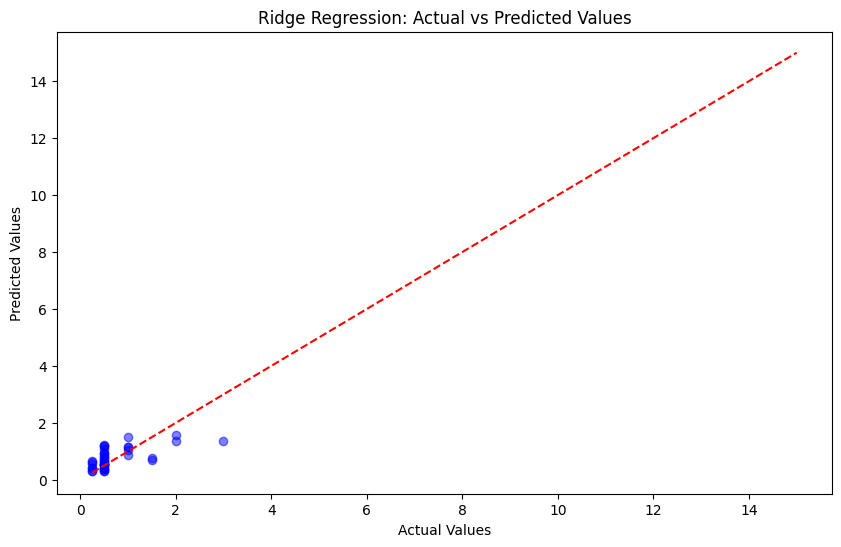

In [84]:
import matplotlib.pyplot as plt

# Create polynomial features
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize and train the Ridge model
model = Ridge(alpha=0.1)
model.fit(X_train_poly, y_train)

# Predict on test data
y_test_pred = model.predict(X_test_poly) 

# Filter the data to include only points within the range [0, 14]
valid_indices = (y_test >= 0) & (y_test <= 14) & (y_test_pred >= 0) & (y_test_pred <= 14)
y_test_filtered = y_test[valid_indices]
y_test_pred_filtered = y_test_pred[valid_indices]

# Scatter plot of actual vs predicted values with specified limits
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_test_pred_filtered, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [100]:
# LINEAR LASSO REGRESSION

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter configurations to test
alpha_values = [0.01, 0.1, 1.0, 10.0]
degree_values = [1, 2, 3]

# Initialize variables to store the best model
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Loop over different configurations
for alpha in alpha_values:
    for degree in degree_values:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)

        # Initialize and train the Lasso model
        model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
        model.fit(X_train_poly, y_train)

        # Predict on training data
        y_train_pred = model.predict(X_train_poly)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        # Predict on test data
        y_test_pred = model.predict(X_test_poly)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Update the best model if this one is better
        if test_r2 > best_test_r2:
            best_model = {
                'Model': 'Lasso Regression',
                'Optimal Configuration': {'alpha': alpha, 'degree': degree},
                'Train MSE': train_mse,
                'Train R2': train_r2,
                'Test MSE': test_mse,
                'Test R2': test_r2
            }
            best_train_mse = train_mse
            best_test_mse = test_mse
            best_train_r2 = train_r2
            best_test_r2 = test_r2

# Append the best model's results to the existing best_model_df
if best_model is not None:
    best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)


print("Best Model Configuration Appended:")
print(best_model_df)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)



Best Model Configuration Appended:
                         Model  \
0             Ridge Regression   
1             Lasso Regression   
2   GradientBoostingRegression   
3      SupportVectorRegression   
4           BayesianRegression   
5                kNNRegression   
6       RandomForestRegression   
7                NeuralNetwork   
8             Lasso Regression   
9             Lasso Regression   
10            Lasso Regression   

                                Optimal Configuration  Train MSE  Train R2  \
0                         {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                         {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2   {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3           {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                       {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   
5                         {'n_neighbors': 10, 'p': 1}   0.731260  0.386732   
6   {'n_es

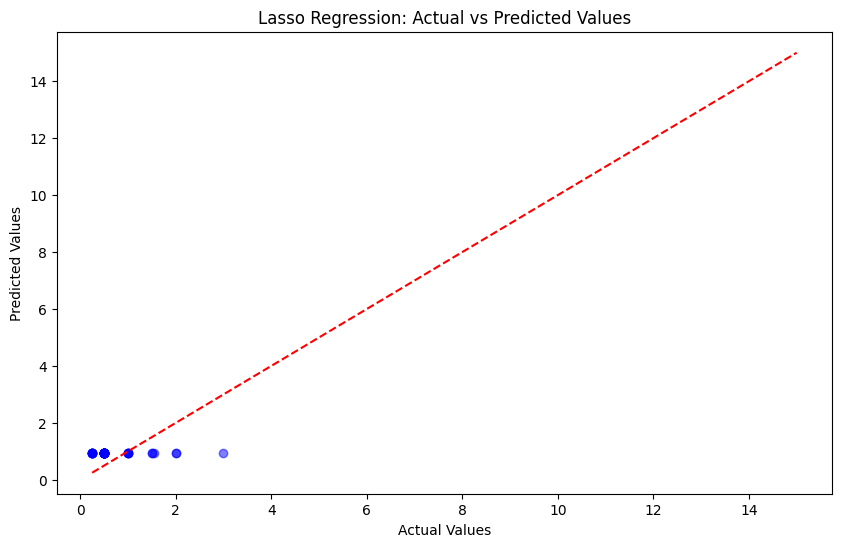

In [102]:
import matplotlib.pyplot as plt

# Create polynomial features
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Initialize and train the Ridge model
model = Lasso(alpha=1.0, random_state=42, max_iter=1000)
model.fit(X_train_poly, y_train)

# Predict on test data
y_test_pred = model.predict(X_test_poly)

valid_indices = (y_test >= 0) & (y_test <= 14) & (y_test_pred >= 0) & (y_test_pred <= 14)
y_test_filtered = y_test[valid_indices]
y_test_pred_filtered = y_test_pred[valid_indices]

# Scatter plot of actual vs predicted values with specified limits
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_test_pred_filtered, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [105]:
# Load the unseen test data
their_test_df = pd.read_csv('their_test.csv')

# Assuming that the features in 'their_test.csv' are the same as in X_train
X_their_test = their_test_df.values

# Scale the unseen test data using the previously fitted scaler
#X_their_test_scaled = scaler.transform(X_their_test)

# Create polynomial features with the degree found in the best model
poly = PolynomialFeatures(degree=1)  # degree=1 as found
X_train_poly = poly.fit_transform(X_train)
X_their_test_poly = poly.transform(X_their_test)

# Use the best trained Lasso model to predict on the unseen test data
best_model_lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)  # alpha=1.0 as found
best_model_lasso.fit(X_train_poly, y_train)

# Predicting on the unseen test data
y_their_test_pred = best_model_lasso.predict(X_their_test_poly)

# Save the predictions to a CSV file or print them
submission_df = pd.DataFrame({
    'Pothole number': their_test_df['pothole_id'],
    'Bags used': y_their_test_pred
})

submission_df.to_csv('lasso_alpha_1.csv', index=False)

print("Predictions on the unseen test data have been saved to 'lasso_alpha_1.csv'.")

Predictions on the unseen test data have been saved to 'lasso_alpha_1.csv'.


/home/alanaubuntu/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [71]:
# GRADIENT BOOSTING REGRESSION
best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Hyperparameter grid
n_estimators_options = [50, 100, 200]
learning_rate_options = [0.01, 0.1, 0.2]
max_depth_options = [3, 5, 7]

# Nested for loop to test different hyperparameter combinations
for n_estimators in n_estimators_options:
    for learning_rate in learning_rate_options:
        for max_depth in max_depth_options:
            # Initialize the model
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )

            # Perform cross-validation on the training set
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
            mean_cv_mse = -cv_scores.mean()

            # Train the model on the full training set and evaluate on the test set
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            train_r2 = r2_score(y_train, y_pred_train)
            train_mse = mean_squared_error(y_train, y_pred_train)

            y_pred_test = model.predict(X_test)
            test_r2 = r2_score(y_test, y_pred_test)
            test_mse = mean_squared_error(y_test, y_pred_test)

            # Print the MSE for this combination of hyperparameters
            #print(f'Params: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}')
            #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

            # Check if this is the best model so far
            if test_r2 > best_test_r2:
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
                best_train_mse = train_mse
                best_test_mse = test_mse
                best_test_r2 = test_r2
                best_train_r2 = train_r2

print(f'Best Hyperparameters: {best_params}')
print(f'Best Test MSE: {best_test_mse}')
print(f'Train MSE of Best Model: {best_train_mse}')

# Prepare the results dictionary
best_model = {
    "Model": "GradientBoostingRegression",
    "Optimal Configuration": best_params,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7}
Best Test MSE: 9.071451677142406
Train MSE of Best Model: 0.01601625051905476
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   

       Test MSE        Test R2  
0  1.847207e+06 -201580.164586  
1  9.339497e+00      -0.019196  
2  9.071452e+00       0.010055  


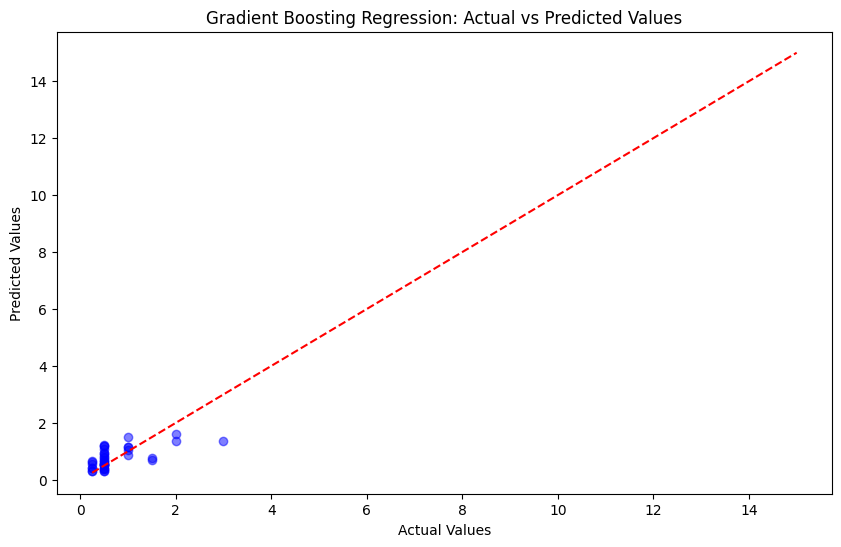

In [86]:
import matplotlib.pyplot as plt

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

valid_indices = (y_test >= 0) & (y_test <= 14) & (y_test_pred >= 0) & (y_test_pred <= 14)
y_test_filtered = y_test[valid_indices]
y_test_pred_filtered = y_test_pred[valid_indices]

# Scatter plot of actual vs predicted values with specified limits
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_test_pred_filtered, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [73]:
# SUPPORT VECTOR REGRESSION

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the kernels to try
kernels = ['linear', 'rbf']

# Define the range of hyperparameters to test
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 1]

best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

best_kernel = None
best_C = None
best_epsilon = None

# Loop through the combinations of kernels, C, and epsilon
for kernel in kernels:
    for C in C_values:
        for epsilon in epsilon_values:
            model = SVR(kernel=kernel, C=C, epsilon=epsilon)
            
            # Perform K-Fold Cross-Validation
            kf = KFold(n_splits=20, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
            
            # Fit the model on the training data
            model.fit(X_train_scaled, y_train)
            
            # Predict on the training and test data
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)
            
            # Round the predicted values to two decimal places
            y_train_pred = np.round(y_train_pred, 2)
            y_test_pred = np.round(y_test_pred, 2)
            
            # Calculate MSE and R2 on the training and test data
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            #print(f'Kernel: {kernel}, C: {C}, epsilon: {epsilon}, Cross-Validation MSE: {-cv_scores.mean()}, Test MSE: {test_mse}')
            
            # Update the best parameters if this model is better
            if test_r2 > best_test_r2:
                best_test_mse = test_mse
                best_train_mse = train_mse
                best_train_r2 = train_r2
                best_test_r2 = test_r2
                best_kernel = kernel
                best_C = C
                best_epsilon = epsilon

print(f'\nBest Kernel: {best_kernel}, Best C: {best_C}, Best epsilon: {best_epsilon}, Best Test MSE: {best_mse}')

# Prepare the results dictionary for the best model
model_name = "SupportVectorRegression"
optimal_config = {
    'kernel': best_kernel,
    'C': best_C,
    'epsilon': best_epsilon
}

best_model = {
    "Model": "SupportVectorRegression",
    "Optimal Configuration": optimal_config,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)


Best Kernel: rbf, Best C: 0.1, Best epsilon: 1, Best Test MSE: 9.166963636363636
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   

       Test MSE        Test R2  
0  1.847207e+06 -201580.164586  
1  9.339497e+00      -0.019196  
2  9.071452e+00       0.010055  
3  9.166964e+00      -0.000368  


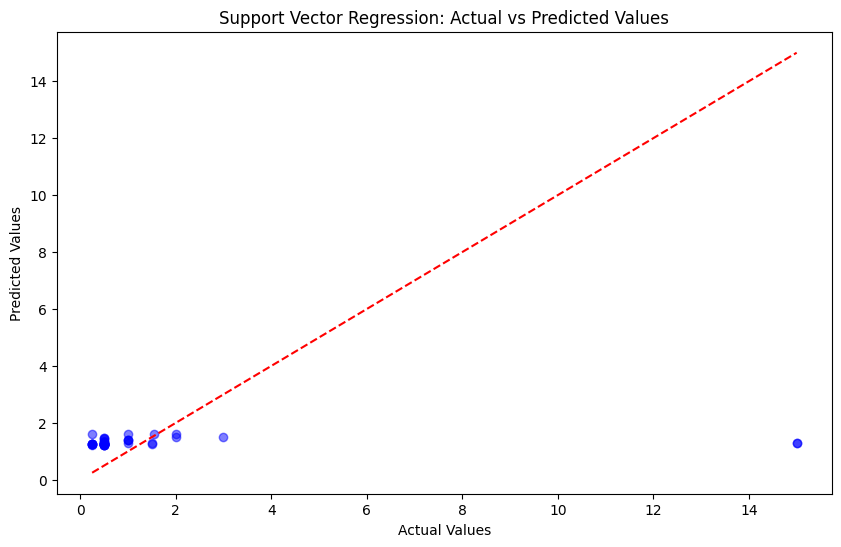

In [74]:
import matplotlib.pyplot as plt

model = SVR(kernel='rbf', C=0.1, epsilon=1)

model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Support Vector Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [75]:
# BAYES REGRESSION

# Initialize lists for storing results
best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Hyperparameter grid
# Define alpha and lambda options for BayesianRidge
alpha_options = [1e-6, 1e-3, 1e-1]
lambda_options = [1e-6, 1e-3, 1e-1]

# Nested for loop to test different hyperparameter combinations
for alpha in alpha_options:
    for lambda_ in lambda_options:
        # Initialize the model
        model = BayesianRidge(alpha_1=alpha, alpha_2=lambda_, lambda_1=alpha, lambda_2=lambda_)

        # Perform cross-validation on the training set
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model_cv = BayesianRidge(alpha_1=alpha, alpha_2=lambda_, lambda_1=alpha, lambda_2=lambda_).fit(X_train_cv, y_train_cv)
            y_pred_val_cv = model_cv.predict(X_val_cv)
            cv_scores.append(mean_squared_error(y_val_cv, y_pred_val_cv))
        mean_cv_mse = np.mean(cv_scores)

        # Train the model on the full training set and evaluate on the test set
        model.fit(X_train, y_train)
        # Predict on the training and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
            
        # Round the predicted values to two decimal places
        y_train_pred = np.round(y_train_pred, 2)
        y_test_pred = np.round(y_test_pred, 2)

        # Calculate MSE and R2 on the training and test data
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Print the MSE for this combination of hyperparameters
        #print(f'Params: alpha={alpha}, lambda={lambda_}')
        #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

        # Check if this is the best model so far
        if test_r2 > best_test_r2:
            best_params = {
                'alpha': alpha,
                'lambda': lambda_
            }
            best_test_mse = test_mse
            best_train_mse = train_mse
            best_train_r2 = train_r2
            best_test_r2 = test_r2

# Output the best hyperparameters, corresponding test MSE, and the train MSE of the best model
print(f'Best Hyperparameters: {best_params}')
print(f'Best Test MSE: {best_test_mse}')
print(f'Train MSE of Best Model: {best_train_mse}')


model_name = "BayesRegression"

optimal_config = {
    "alpha": alpha,
    "lambda": lambda_
}

# Prepare the results dictionary
best_model = {
    "Model": "BayesianRegression",
    "Optimal Configuration": optimal_config,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

Best Hyperparameters: {'alpha': 1e-06, 'lambda': 0.001}
Best Test MSE: 1847207.0910954543
Train MSE of Best Model: 0.8142631299734749
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   
4          BayesianRegression   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                      {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   

       Test MSE        Test R2  
0  1.847207e+06 -201580.164586  
1  9.339497e+00      -0.019196  
2  9.071452e+00       0.010055  
3  9.166964e+00      -0.000368  
4  1

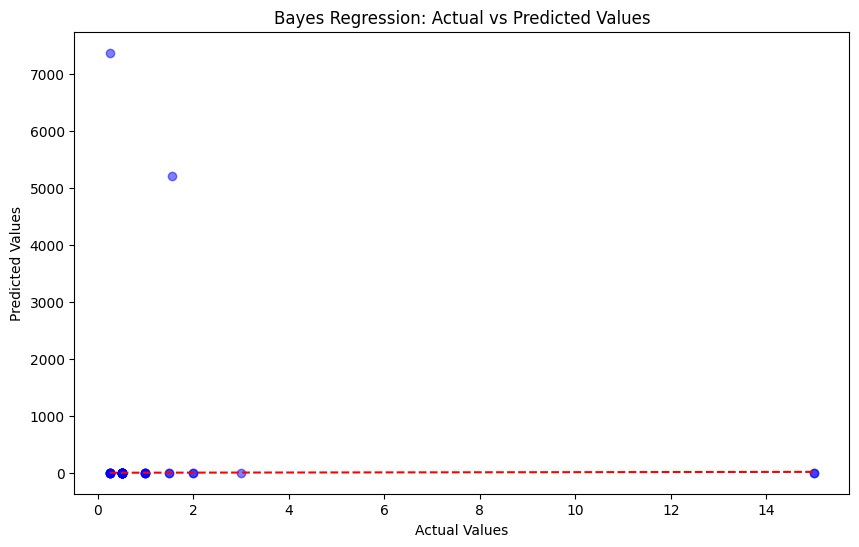

In [76]:
import matplotlib.pyplot as plt

model = BayesianRidge(alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Bayes Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [77]:
# kNN REGRESSION

# Initialize lists for storing results
best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Hyperparameter grid
n_neighbors_options = [3, 5, 7, 10]
p_options = [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance

# Nested for loop to test different hyperparameter combinations
for n_neighbors in n_neighbors_options:
    for p in p_options:
        # Initialize the model
        model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p)

        # Perform cross-validation on the training set
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        mean_cv_mse = -cv_scores.mean()

        # Train the model on the full training set and evaluate on the test set
        model.fit(X_train, y_train)
        # Predict on the training and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
            
        # Round the predicted values to two decimal places
        y_train_pred = np.round(y_train_pred, 2)
        y_test_pred = np.round(y_test_pred, 2)

        # Calculate MSE and R2 on the training and test data
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Print the MSE for this combination of hyperparameters
        #print(f'Params: n_neighbors={n_neighbors}, p={p}')
        #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

        # Check if this is the best model so far
        if test_r2 > best_test_r2:
            best_params = {
                'n_neighbors': n_neighbors,
                'p': p
            }
            best_test_mse = test_mse
            best_train_mse = train_mse
            best_train_r2 = train_r2
            best_test_r2 = test_r2

print(f'Best Hyperparameters: {best_params}')
print(f'Best Test MSE: {best_test_mse}')
print(f'Train MSE of Best Model: {best_train_mse}')

# Prepare the results dictionary
best_model = {
    "Model": "kNNRegression",
    "Optimal Configuration": best_params,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

Best Hyperparameters: {'n_neighbors': 10, 'p': 1}
Best Test MSE: 10.140547727272727
Train MSE of Best Model: 0.7312602122015914
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   
4          BayesianRegression   
5               kNNRegression   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                      {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   
5                        {'n_neighbors': 10, 'p': 1}   0.731260  0.386732   

       Test MSE        Test R2  
0  1.847207e+06 -201580.164586  

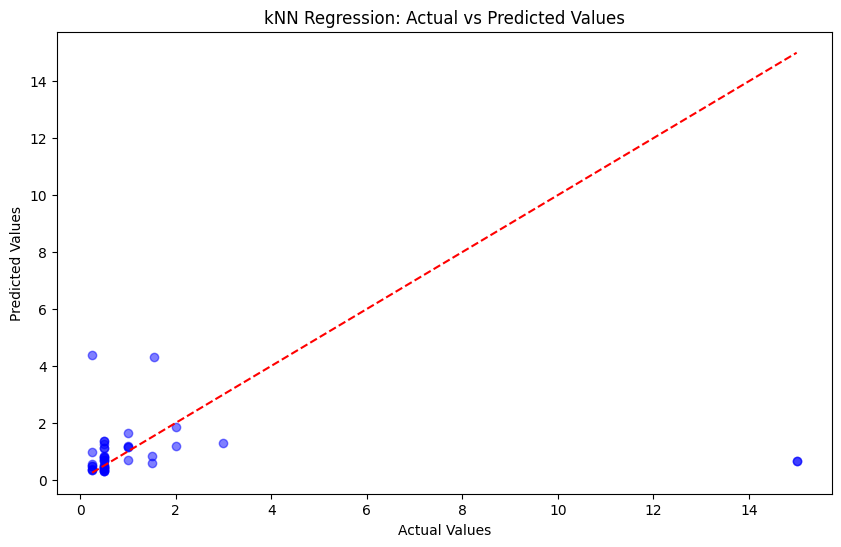

In [78]:
import matplotlib.pyplot as plt

model = KNeighborsRegressor(n_neighbors=10, p=1)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('kNN Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [79]:
# RANDOM FOREST REGRESSION

# Initialize lists for storing results
best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Hyperparameter grid
n_estimators_options = [50, 100, 200]
max_depth_options = [None, 10, 20, 30]
min_samples_split_options = [2, 5, 10]

# Nested for loop to test different hyperparameter combinations
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        for min_samples_split in min_samples_split_options:
            # Initialize the model
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )

            # Perform cross-validation on the training set
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
            mean_cv_mse = -cv_scores.mean()

            # Train the model on the full training set and evaluate on the test set
            model.fit(X_train, y_train)
            # Predict on the training and test data
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Round the predicted values to two decimal places
            y_train_pred = np.round(y_train_pred, 2)
            y_test_pred = np.round(y_test_pred, 2)

            # Calculate MSE and R2 on the training and test data
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # Print the MSE for this combination of hyperparameters
            #print(f'Params: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}')
            #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

            # Check if this is the best model so far
            if test_r2 > best_test_r2:
                
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }
                best_test_mse = test_mse
                best_train_mse = train_mse
                best_train_r2 = train_r2
                best_test_r2 = test_r2

# Output the best hyperparameters, corresponding test MSE, and the train MSE of the best model
print(f'Best Hyperparameters: {best_params}')
print(f'Best Test MSE: {best_test_mse}')
print(f'Train MSE of Best Model: {best_train_mse}')

# Prepare the results dictionary
best_model = {
    "Model": "RandomForestRegression",
    "Optimal Configuration": best_params,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
Best Test MSE: 9.759395454545457
Train MSE of Best Model: 0.1374919098143236
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   
4          BayesianRegression   
5               kNNRegression   
6      RandomForestRegression   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                      {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   
5                        {'n_neighbors': 10, 'p': 1}   0.731260  0.386732 

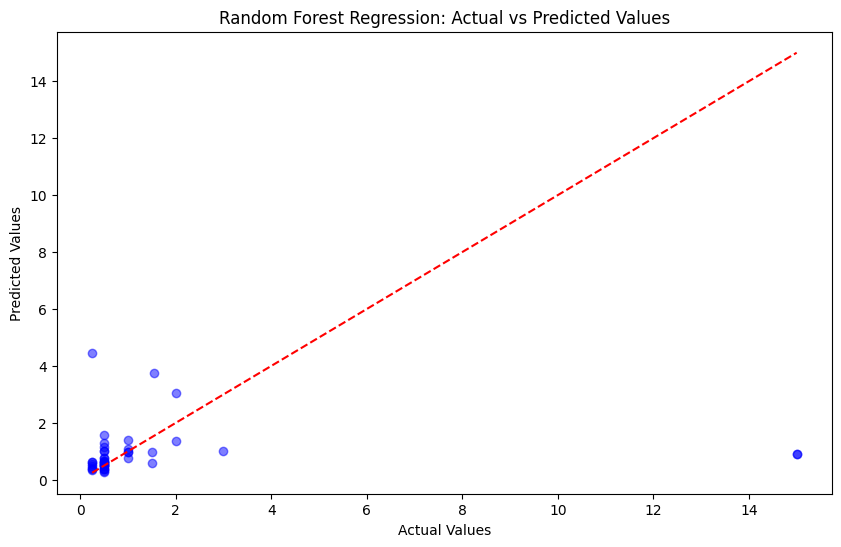

In [80]:
import matplotlib.pyplot as plt

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: Actual vs Predicted Values')

# Show plot
plt.show()

In [81]:
# NEURAL NETWORK

best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Hyperparameters to test
hidden_dims = [(64, 32), (128, 64), (64, 64)]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [10, 20, 30]
num_epochs = 100

# Initialize lists for storing results
results = []

# Loop over different hyperparameters
for hidden_dim1, hidden_dim2 in hidden_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Create a dataset and data loader with the current batch size
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Define the neural network model
            class SimpleNN(nn.Module):
                def __init__(self, input_dim, hidden_dim1, hidden_dim2):
                    super(SimpleNN, self).__init__()
                    self.fc1 = nn.Linear(input_dim, hidden_dim1)
                    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
                    self.fc3 = nn.Linear(hidden_dim2, 1)
                    self.relu = nn.ReLU()

                def forward(self, x):
                    x = self.relu(self.fc1(x))
                    x = self.relu(self.fc2(x))
                    x = self.fc3(x)
                    return x

            # Initialize the model
            input_dim = X_train_scaled.shape[1]
            model = SimpleNN(input_dim, hidden_dim1, hidden_dim2)

            # Define loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Train the model
            for epoch in range(num_epochs):
                for X_batch, y_batch in train_loader:
                    # Forward pass
                    outputs = model(X_batch)
                    loss = criterion(outputs.squeeze(), y_batch)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluate the model
            with torch.no_grad():
                y_train_pred = model(X_train_tensor).squeeze().numpy()
                y_test_pred = model(X_test_tensor).squeeze().numpy()

            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # Store results
            results.append({
                'hidden_dim1': hidden_dim1,
                'hidden_dim2': hidden_dim2,
                'learning_rate': lr,
                'batch_size': batch_size,
                'train_mse': train_mse,
                'test_mse': test_mse
            })

            # Check if this is the best model so far
            if test_r2 > best_test_r2:
                
                best_params = {
                    'hidden_dim1': hidden_dim1,
                    'hidden_dim2': hidden_dim2,
                    'learning_rate': lr,
                    'batch_size': batch_size,
                }
                best_test_mse = test_mse
                best_train_mse = train_mse
                best_train_r2 = train_r2
                best_test_r2 = test_r2

            #print(f'Hidden Layers: {hidden_dim1}, {hidden_dim2} | LR: {lr} | Batch Size: {batch_size}')
            #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

# Find the best hyperparameters
best_result = min(results, key=lambda x: x['test_mse'])
print(f'Best Hyperparameters: {best_result}')

# Prepare the results dictionary
best_model = {
    "Model": "NeuralNetwork",
    "Optimal Configuration": best_params,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have t

Best Hyperparameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'learning_rate': 0.001, 'batch_size': 10, 'train_mse': 8.622466945113314e-05, 'test_mse': 9.071451677142406}
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   
4          BayesianRegression   
5               kNNRegression   
6      RandomForestRegression   
7               NeuralNetwork   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                      {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   
5                        {'n_neighb

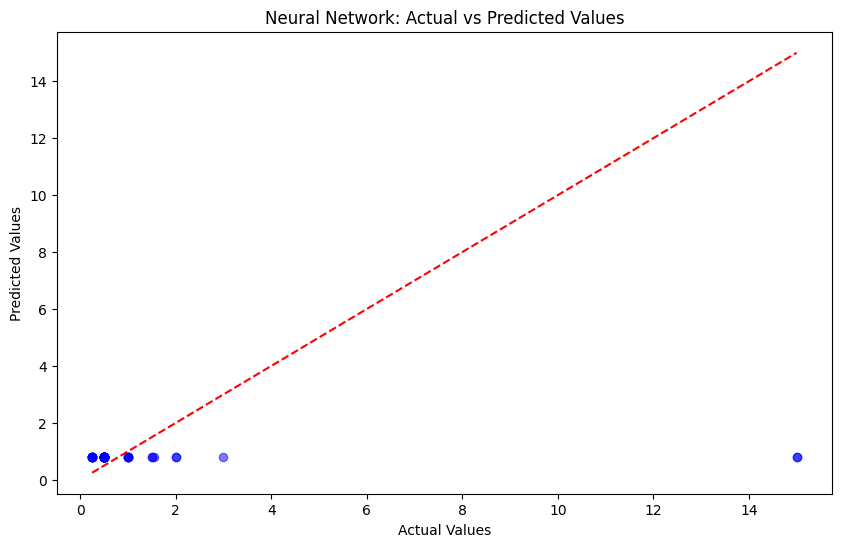

In [88]:
import matplotlib.pyplot as plt

batch_size = 10
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = X_train_scaled.shape[1]
model = SimpleNN(input_dim, 64, 64)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
with torch.no_grad():
    #y_train_pred = model(X_train_tensor).squeeze().numpy()
    y_test_pred = model(X_test_tensor).squeeze().numpy()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)

# Plot the line where the predicted values match the actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Actual vs Predicted Values')

# Show plot
plt.show()

In [ ]:
# NEURAL NETWORK

best_model = None
best_train_r2 = -float('inf')
best_test_r2 = -float('inf')
best_train_mse = float('inf')
best_test_mse = float('inf')

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Hyperparameters to test
hidden_dims = [(64, 32), (128, 64), (64, 64)]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [10, 20, 30]
num_epochs = 100

# Initialize lists for storing results
results = []

# Loop over different hyperparameters
for hidden_dim1, hidden_dim2 in hidden_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Create a dataset and data loader with the current batch size
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Define the neural network model
            class SimpleNN(nn.Module):
                def __init__(self, input_dim, hidden_dim1, hidden_dim2):
                    super(SimpleNN, self).__init__()
                    self.fc1 = nn.Linear(input_dim, hidden_dim1)
                    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
                    self.fc3 = nn.Linear(hidden_dim2, 1)
                    self.relu = nn.ReLU()

                def forward(self, x):
                    x = self.relu(self.fc1(x))
                    x = self.relu(self.fc2(x))
                    x = self.fc3(x)
                    return x

            # Initialize the model
            input_dim = X_train_scaled.shape[1]
            model = SimpleNN(input_dim, hidden_dim1, hidden_dim2)

            # Define loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Train the model
            for epoch in range(num_epochs):
                for X_batch, y_batch in train_loader:
                    # Forward pass
                    outputs = model(X_batch)
                    loss = criterion(outputs.squeeze(), y_batch)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluate the model
            with torch.no_grad():
                y_train_pred = model(X_train_tensor).squeeze().numpy()
                y_test_pred = model(X_test_tensor).squeeze().numpy()

            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # Store results
            results.append({
                'hidden_dim1': hidden_dim1,
                'hidden_dim2': hidden_dim2,
                'learning_rate': lr,
                'batch_size': batch_size,
                'train_mse': train_mse,
                'test_mse': test_mse
            })

            # Check if this is the best model so far
            if test_r2 > best_test_r2:
                
                best_params = {
                    'hidden_dim1': hidden_dim1,
                    'hidden_dim2': hidden_dim2,
                    'learning_rate': lr,
                    'batch_size': batch_size,
                }
                best_test_mse = test_mse
                best_train_mse = train_mse
                best_train_r2 = train_r2
                best_test_r2 = test_r2

            #print(f'Hidden Layers: {hidden_dim1}, {hidden_dim2} | LR: {lr} | Batch Size: {batch_size}')
            #print(f'Train MSE: {train_mse:.5f}, Test MSE: {test_mse:.5f}\n')

# Find the best hyperparameters
best_result = min(results, key=lambda x: x['test_mse'])
print(f'Best Hyperparameters: {best_result}')

# Prepare the results dictionary
best_model = {
    "Model": "NeuralNetwork",
    "Optimal Configuration": best_params,
    'Train MSE': best_train_mse,
    'Train R2': best_train_r2,
    'Test MSE': best_test_mse,
    'Test R2': best_test_r2
}

# Append the best model to the existing best_model_df
best_model_df = pd.concat([best_model_df, pd.DataFrame([best_model])], ignore_index=True)

# Optional: Save the updated best_model_df to a CSV file
best_model_df.to_csv('best_model_df.csv', index=False)

print("Best Model Configuration Appended:")
print(best_model_df)

/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alanaubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have t

Best Hyperparameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'learning_rate': 0.001, 'batch_size': 10, 'train_mse': 8.622466945113314e-05, 'test_mse': 9.071451677142406}
Best Model Configuration Appended:
                        Model  \
0            Ridge Regression   
1            Lasso Regression   
2  GradientBoostingRegression   
3     SupportVectorRegression   
4          BayesianRegression   
5               kNNRegression   
6      RandomForestRegression   
7               NeuralNetwork   

                               Optimal Configuration  Train MSE  Train R2  \
0                        {'alpha': 0.1, 'degree': 1}   0.814519  0.316907   
1                        {'alpha': 1.0, 'degree': 1}   1.192399  0.000000   
2  {'n_estimators': 100, 'learning_rate': 0.1, 'm...   0.016016  0.986568   
3          {'kernel': 'rbf', 'C': 0.1, 'epsilon': 1}   1.215035 -0.018984   
4                      {'alpha': 0.1, 'lambda': 0.1}   0.814263  0.317122   
5                        {'n_neighb